# WEEK 41 - EXERCISES - gradient descent
By Gerlind Deschner.


I consider the function $f(x) = 1 - 2x + 1/3x^2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [4]:
np.random.seed(1)
n = 100
# Make data set.
x = np.linspace(-1,6, n).reshape(-1, 1)
y = 1 - 2*x +1/3*x**2

X = np.c_[np.ones((n,1)),x, x**2]
#yr = 1 - 2*x +1/3*x**2 + (np.random.rand(n,1) - 0.5)

<function matplotlib.pyplot.show(close=None, block=None)>

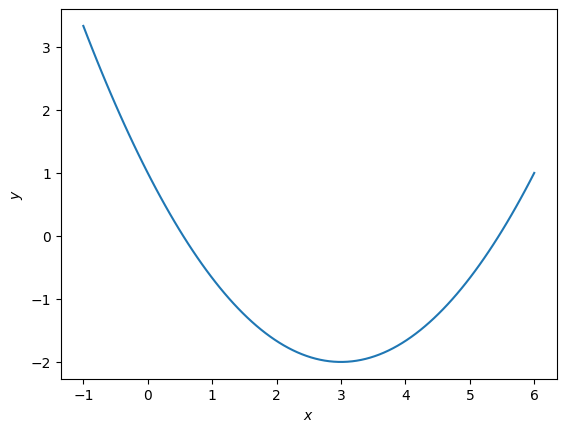

In [5]:
plt.plot(x,y)
#plt.plot(x,yr,'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show

## Gradient descent / steepest descent
First we consider OLS regression, and thus the function that we want to minimize is $$C(\beta) = 1/n \| X\beta - y \|^2_2 = 1/n (X\beta - y)^\top (X\beta - y) = 1/n \beta^\top X^\top X \beta - 2/n \beta^\top X^\top y + 1/n y^\top y$$
So we know that the gradient w.r.t $\beta$ is $$\nabla C(\beta) = 2/n X^\top (X\beta - y)$$
Since the second derivative is $2/n X^\top X$, which is positive semidefinite, we know that $C(\beta)$ is convex.

In [53]:
def gradient_C_MSE(X,y,beta):
    n = y.size
    return 2.0/n * X.T @(X@ beta -y)

def gd_fixgamma(X,y,f_gradient):
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    '''''' 
    H = (2.0/n)* X.T @ X
    # Get the eigenvalues
    EigValues, EigVectors = np.linalg.eig(H)
    gamma = 1.0/np.max(EigValues) # optimum stepssize wrt to deeplearningbook.org page 86

    ''''''
    #gamma = 0.001
    
    Niterations = 1000
    for iter in range(Niterations):
        xk -= gamma*f_gradient(X,y,xk)
    beta_GD = xk
    return beta_GD



In [57]:

beta_GD = gd_fixgamma(X,y, gradient_C_MSE)
print(beta_GD)

beta_linreg = np.linalg.inv(X.T @ X) @ X.T @ y
print(beta_linreg)

[[ 0.35698023]
 [-1.48224587]
 [ 0.25567046]]
[[ 1.        ]
 [-2.        ]
 [ 0.33333333]]


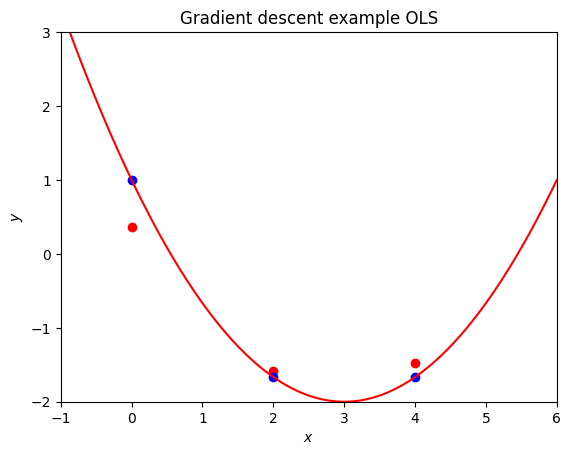

In [58]:
xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]
ypredict = xbnew.dot(beta_GD)
ypredict2 = xbnew.dot(beta_linreg)
#ypredict2_0 = xbnew.dot(beta_steep)
plt.plot(xnew, ypredict, "ro")
plt.plot(xnew, ypredict2, "bo")
#plt.plot(xnew, ypredict2_0, "orange", marker = 'o', linestyle = ' ')
plt.plot(x, y ,'r')
plt.axis([-1.0,6.0,-2.0, 3.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent example OLS')
plt.show()

Here we implemented the plain gradient descent (GD) with a fixed learning rate, in particular we used as learning rate the inverse of the maximum eigenvalue of the second derivative matrix, as suggested in the book on the deeplearningbook.org website on page 86. This seems to work really well for this case. Trying other values, we can see that gamma = 0.001 works still okay with a number of iterations of 1000. But a larger gamma causes problems, and a smaller needs more iterations.


## plain gradient descent with momentum
Now we implement plain gradient descent with a fixed gamma and momentum. For the momentum of 0.9, and gamma again equal to the inverse of the maximum eigenvalue works nearly perfectly. A smaller momentum, e.g. 0.3 seems to behave worse and larger values seem to bring again more variability, but it is pretty stable for 0.9.
The convergenc in this is even better than the plain gradient descent convergence.

In [46]:
def gd_momentum(X,y,f_grad, Niter=1000, gamma=0.001, moment=0.3):
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta
    change=0.0
    
    for iter in range(Niter):
        change = gamma*f_grad(X,y,xk) + moment*change
        xk -= change
    beta_GD = xk
    return beta_GD

[[ 0.81877706]
 [-1.86147055]
 [ 0.31300297]]


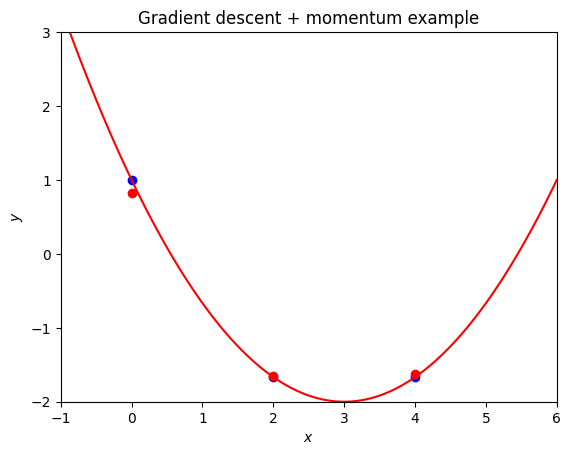

In [76]:
H = (2.0/n)* X.T @ X
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
gamma = 1.0/np.max(EigValues) # optimum stepssize wrt to deeplearningbook.org page 86


beta_GD_mo = gd_momentum(X,y, gradient_C_MSE, Niter=200, gamma=gamma, moment = 0.9)
print(beta_GD_mo)
ypredict3 = xbnew.dot(beta_GD_mo)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict2, "bo")
plt.plot(xnew, ypredict3, "ro")
plt.plot(x, y ,'r')
plt.axis([-1.0,6.0,-2.0, 3.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent + momentum example')
plt.show()

## now for stochastic GD with scaling in form of time decay rate

can we write $\nabla C(\beta) = \sum_{i=1}^n \nabla c_i(x_i, \beta)$ ?
$$\nabla C(\beta) = 2/n X^\top (X\beta - y) = 2/n 
\begin{bmatrix} \sum_{i=1}^n x_{i,1} ( \sum_{j=1}^p x_{i,j}\beta_j - y_i) \\ \dots \\ \sum_{i=1}^n x_{i,p} ( \sum_{j=1}^p x_{i,j}\beta_j - y_i) \end{bmatrix} $$
In particular, we have $x_{i,j} = x_i^{j-1}$, so 
$$\nabla C(\beta) = 2/n 
\begin{bmatrix} 
\sum_{i=1}^n 1 ( \sum_{j=1}^p x_{i}^{j-1} \beta_j - y_i) \\ 
\sum_{i=1}^n x_{i} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \\ 
\dots \\ 
\sum_{i=1}^n x_{i}^{p-1} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \end{bmatrix} $$

$$\nabla C(\beta) = 2/n \sum_{i=1}^n 
\begin{bmatrix} 
1 ( \sum_{j=1}^p x_{i}^{j-1} \beta_j - y_i) \\ 
 x_{i} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \\ 
\dots \\ 
 x_{i}^{p-1} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \end{bmatrix} $$
So, we can define $$ \nabla c_i(x_i, \beta) =  2/n  
\begin{bmatrix} 
1 ( \sum_{j=1}^p x_{i}^{j-1} \beta_j - y_i) \\ 
 x_{i} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \\ 
\dots \\ 
 x_{i}^{p-1} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \end{bmatrix} =2/n ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \begin{bmatrix} 1\\ x_i \\ \dots \\ x_i^{p-1} \end{bmatrix} $$

 So the sum of $i \in S \subset \{1, \dots, n\}$ is 
 $$ \sum_{i \in S} \nabla c_i(x_i, \beta)  =2/n ( \sum_{j=1}^p x_{i_1}^{j-1}\beta_j - y_{i_1}) \begin{bmatrix} 1\\ x_{i_1} \\ \dots \\ x_{i_1}^{p-1} \end{bmatrix}  + 2/n( \sum_{j=1}^p x_{i_2}^{j-1}\beta_j - y_{i_2}) \begin{bmatrix} 1\\ x_{i_2} \\ \dots \\ x_{i_2}^{p-1} \end{bmatrix} + \dots = 2/n X_S^\top (X_S\beta - y_S)$$

In [77]:
def c_i(x_istar,beta, y_i,n):
    x_istar = x_istar.reshape((x_istar.size,1))
    coeff = 2.0/n * x_istar.T @ beta - y_i
    return coeff *x_istar

def sum_c_i(X_sub, beta, y_sub,n): # Xsub is a X from which rows are deleted, same for y_sub
    return X_sub.T @ ((X_sub @ beta) - y_sub) *2/n
    #TODO IWIE MACHEN ALLE DIESES AVERAGINING MIT 1/M ABER KA WIESO

def gamma_timedecay(t,t0,t1):
    if t0 <= 0 or t1 <= 0:
        raise ValueError("t0 or t1 <= 0")
    return t0/(t+t1)


In [78]:
def sgd(X,y,sum_c_i, n_epochs=50, M=5, t0=1,t1=10, gam = 0):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta
    xks.append(xk)
    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches

    for e in range(n_epochs):
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient = sum_c_i(Xi, xk, yi,n) # 1/M
            if gam:
                gamma = gam

            else: 
                gamma = gamma_timedecay(e*m + i,t0,t1)
            xk = xk - gamma*gradient
            xks.append(xk)
            
        

    return xk

[[ 0.84568041]
 [-1.88079861]
 [ 0.31545672]]


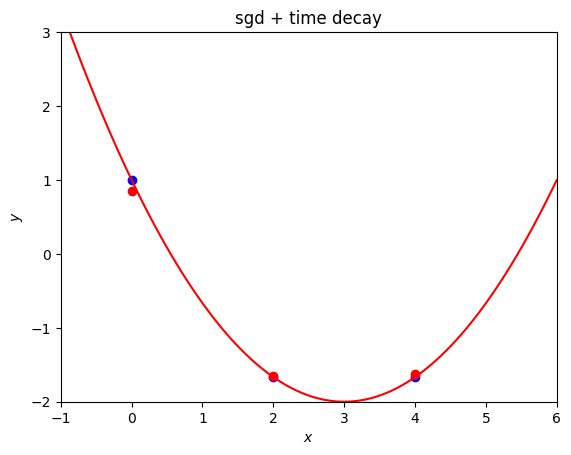

In [109]:
n_epochs = 500
M = 10 # size of the minibatches
t0, t1 = M, n_epochs # taking 1,10 decays faster than 5,50, eventough they have the smae starting point
xks = []

# want to try fixed learning rate
H = (2.0/n)* X.T @ X
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
gamma = 1.0/np.max(EigValues) # optimum stepssize wrt to deeplearningbook.org page 86
gamma = 0.01

beta_sgd = sgd(X,y,sum_c_i,n_epochs, M, t0,t1, gamma)
print(beta_sgd)
ypredict4 = xbnew.dot(beta_sgd)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict2, "bo")
plt.plot(xnew, ypredict4, "ro")
plt.plot(x, y ,'r')
plt.axis([-1.0,6.0,-2.0, 3.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'sgd + time decay')
plt.show()

Here we now implemented the stochastic gradient  method. In order to get stable and good results, the number of epochs has to be very high, about 500, with a batch size between 5 and 15. If the batch size is larger, it gets less stable. The same applies to the number of epochs if we decrease them. This holds for the learning rate 0.01. If we choose it smaller, it gets less stable and for larger values we get convergence problems. There does not seem to be a particular rule about how these parameters behave and they need careful tuning.

## sgd with scaling in form of time decay rate + momentum


In [112]:
# note by setting momentum = 0, we have the old sgd
def sgd_momentum(X,y,sum_c_i, n_epochs=50, M=5, t0=1,t1=10, momentum = 0.9):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    change = 0
    for e in range(n_epochs):
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n)
            gamma = gamma_timedecay(e*m + i,t0,t1)
            change = gamma*gradient + change*momentum
            xk = xk - change

    return xk

[[ 0.96534761]
 [-1.97276925]
 [ 0.32968433]]


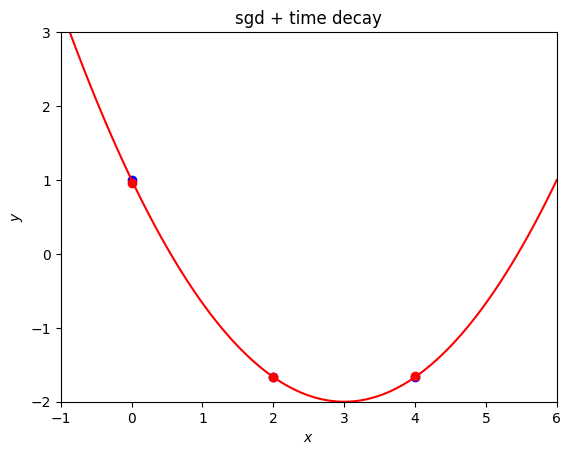

In [212]:
n_epochs = 100 
M = 15 # size of the minibatches
t0, t1 = 1, 30

beta_sgdm = sgd_momentum(X,y,sum_c_i,n_epochs, M, t0,t1, 0.94)
print(beta_sgdm)
ypredict5 = xbnew.dot(beta_sgdm)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict2, "bo")
plt.plot(xnew, ypredict5, "ro")
plt.plot(x, y ,'r')
plt.axis([-1.0,6.0,-2.0, 3.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'sgd + time decay')
plt.show()

Here we consider SGD but with a learning rate that is flexible, we use the time decay form. Additionally, momentum is now added.
Again, we found that the momentum 0.94 works well, other values again bring in more variability between the different solutions. Also, we are now able to reduce the number of epochs to 100, which is only a fifth of the number of epochs for the SGD we had before. By picking the batch size equal to 15, the estimated values get very close to the optimum and are nearly idential. This folds for picking t1 30 and  t0 1 for the learning rate. If those values are changed, a lot of variability is brought into the solutions.

## ADAGRAD with SGD with & witohut momentum

In [219]:
# note by setting momentum = 0, we have the old sgd
def sgd_momentum_adagrad(X,y,sum_c_i, n_epochs=50, M=5, gamma=0.001, momentum = 0.9,delta=1e-8):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    change = 0.0
    for e in range(n_epochs):
        Giter = 0.0
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n)
            Giter += gradient*gradient
            change = gamma*gradient/(delta + np.sqrt(Giter)) + change*momentum
            xk = xk - change

    return xk

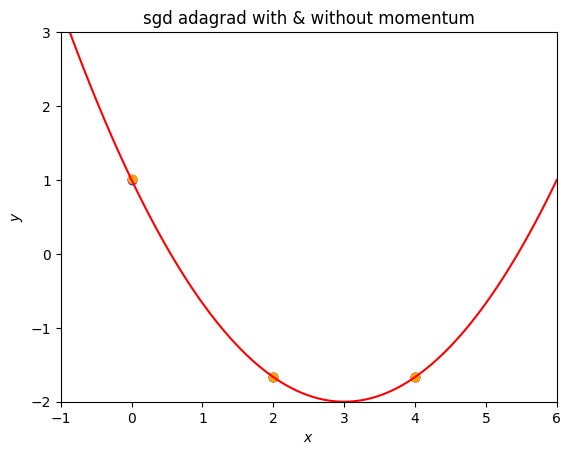

In [286]:
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8
gamma=0.01
M= 5
n_epochs = 100
beta_sgd_adagr_nomom = sgd_momentum_adagrad(X,y,sum_c_i, n_epochs, M, gamma, momentum = 0.0, delta=1e-8)
beta_sgd_adagr_mom = sgd_momentum_adagrad(X,y,sum_c_i, n_epochs, M, gamma, momentum = 0.94, delta=1e-8)

#print(beta_sgd_adagr_nomom)
#print(beta_sgd_adagr_mom)
ypredict6 = xbnew.dot(beta_sgd_adagr_nomom)
ypredict7 = xbnew.dot(beta_sgd_adagr_mom)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict2, "bo")
plt.plot(xnew, ypredict6, "ro")
plt.plot(xnew, ypredict7, "orange", marker ='o', linestyle = ' ')
plt.plot(x, y ,'r')
plt.axis([-1.0,6.0,-2.0, 3.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'sgd adagrad with & without momentum')
plt.show()

Now the Adagrad method is considered for changing the learning rate gamma. For the momentum 0.94 we see again that the estimate is nearly perfect for 70 epochs and batch size M = 5. Again, if the momentum is larger there comes not more variability  however. But if M is changed, variability is introduced, e.g. if M = 10 already. THis was for gamma = 0.001. It behaves slightly better for gamma = 0.01. For this values the estimate without momentum was still not very good. But by increasing the number of epochs to 100, even that estimate got pretty stable.

## RMS PROP (SGD)

In [292]:
# note by setting momentum = 0, we have the old sgd
def sgd_rmsprop(X,y,sum_c_i, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, delta=1e-8):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    change = 0.0
    for e in range(n_epochs):
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n)
            Giter = gradient*gradient
            change = (1- momentum)*Giter + change*momentum
            xk = xk - gamma*gradient/(np.sqrt(change) + delta)

    return xk

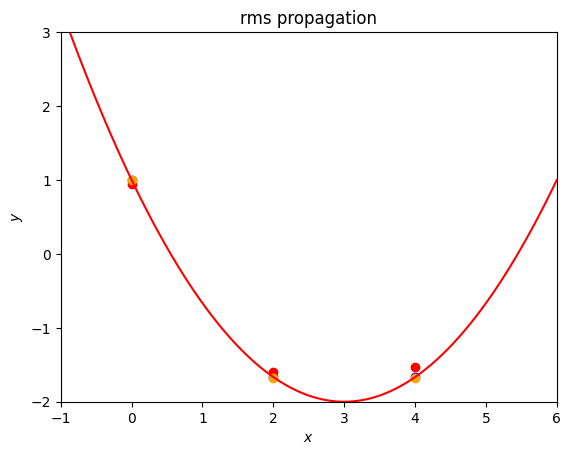

In [379]:
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8
gamma=0.01
M= 5
n_epochs = 70
beta_nomom = sgd_rmsprop(X,y,sum_c_i, n_epochs, M, gamma, momentum = 0.0, delta=1e-8)
beta_mom = sgd_rmsprop(X,y,sum_c_i, n_epochs, M, gamma, momentum = 0.94, delta=1e-8)


ypredict6 = xbnew.dot(beta_nomom)
ypredict7 = xbnew.dot(beta_mom)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict2, "bo")
plt.plot(xnew, ypredict6, "ro")
plt.plot(xnew, ypredict7, "orange", marker ='o', linestyle = ' ')
plt.plot(x, y ,'r')
plt.axis([-1.0,6.0,-2.0, 3.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'rms propagation')
plt.show()

For the momentum 0.94 and the momentum 0, batchsize = 10 and gamma 0.01 and number of epochs 70 we get a good behavement of the estimates. If we decrease the number of epochs this again gets worse. Decreasing gamma also makes it worse again, so as increasing it. Taking the batch size = 5 also seems to be less stable. Of course, if the number of epochs is increased the results gets better, but increasing it to about 60 also brings worse results.

## ADAM(SGD)

In [381]:
# note by setting momentum = 0, we have the old sgd
def sgd_adam(X,y,sum_c_i, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, secmomentum = 0.99, delta=1e-8):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    
    
    for e in range(n_epochs):
        mk = 0.0
        sk= 0.0
        for k in range(1, m+1):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n)
            Giter = gradient*gradient
            mk = ((1- momentum)*gradient + momentum*mk)/(1- momentum**k)
            sk = ((1- secmomentum)*Giter + secmomentum*sk)/(1-secmomentum**k)
            xk = xk - gamma*mk/(np.sqrt(sk) + delta)

    return xk

[[ 0.94206081]
 [-1.91169946]
 [ 0.31767208]]


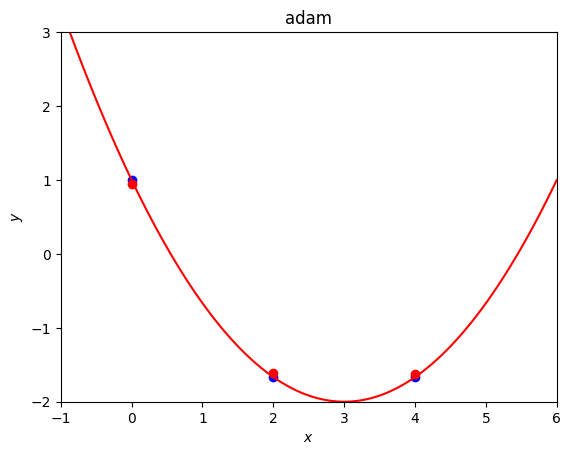

In [583]:
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8

beta_sgd_adam = sgd_adam(X,y,sum_c_i, n_epochs=60, M=5, gamma=0.01, momentum = 0.7, secmomentum = 0.8, delta=1e-8)

print(beta_sgd_adam)
ypredict11 = xbnew.dot(beta_sgd_adam)
plt.plot(xnew, ypredict2, "bo")
plt.plot(xnew, ypredict11, "ro")
plt.plot(x, y ,'r')
plt.axis([-1.0,6.0,-2.0, 3.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'adam')
plt.show()

Now we consider the Adam method for tuning the learning rate. We have that the estimate  for 60 epochs a momentum of 0.7 a second momentum of 0.8 and batch size 5 brings good results. If the batch size is larger, it gets more unstable. The same holds for other moments. The number of epochs behaves as before but now we manage to get good results for only 60 epochs.

# RIDGE now

In [587]:
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1,1,10]
num_lambdas = len(lambdas)

In [588]:
import numpy as np
import matplotlib.pyplot as plt 

In [589]:
np.random.seed(1)
n = 100
# Make data set.
x = np.linspace(-1,6, n).reshape(-1, 1)
y = 1 - 2*x +1/3*x**2


X = np.c_[np.ones((n,1)),x, x**2]

## gradient descent for ridge

In [627]:
def gradient_C_RIDGE(X,y,beta,lamb):
    n = y.size
    return 2.0/n * X.T @(X@ beta -y) + 2.0* lamb*beta

def gd_fixgamma(X,y,lamb, f_grad):
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta
   
    '''''' 
    H = (2.0/n)* X.T @ X + 2.0*lamb
    # Get the eigenvalues
    EigValues, EigVectors = np.linalg.eig(H)
    gamma = 1.0/np.max(EigValues) # optimum stepssize wrt to deeplearningbook.org page 86

    ''''''
    gamma = 0.001
    
    Niterations = 10000
    for iter in range(Niterations):
        xk -= gamma*f_grad(X,y,xk,lamb)
    beta_GD = xk
    return beta_GD

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

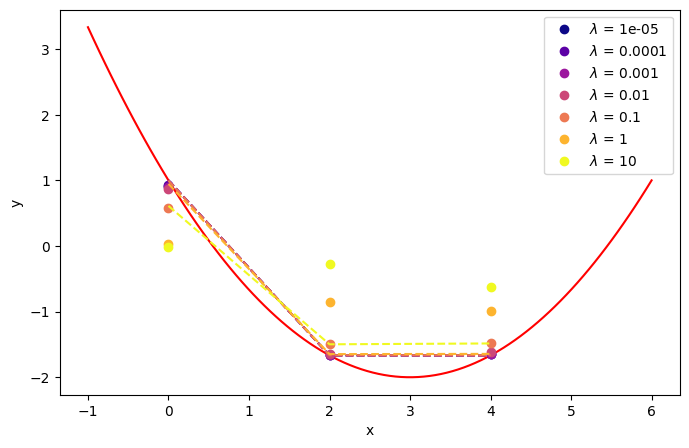

In [628]:
betas_GD = np.zeros((num_lambdas, 3))
betas_RI = np.zeros((num_lambdas, 3))
i = 0
for lamb in lambdas: 
    betas_GD[i] = gd_fixgamma(X,y,lamb,gradient_C_RIDGE).T
    betas_RI[i] = (np.linalg.inv(X.T @ X + lamb*np.identity(X.shape[1])) @ X.T @ y).T #without intercept
    i += 1

import matplotlib as mpl

# colours for lambdas
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, num_lambdas))

fig = plt.figure(figsize=(8, 5))
axs = plt.gca()

axs.plot(x,y,'r')


xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]

it = 0
for lamb in lambdas:
    ypredict = xbnew.dot(betas_GD[it])
    ypredict2 = xbnew.dot(betas_RI[it])
    axs.plot(xnew,ypredict, marker='o', linestyle=' ', c = colors[it], label=r'$\lambda$ = {}'.format(lamb))
    axs.plot(xnew,ypredict2, linestyle='--', c = colors[it])
    
    it += 1

axs.legend()

axs.set(xlabel =r'x', ylabel= r'y')

Here we have now the analysis for the Ridge minimzation function, apart from that, this function and the following functions are the same. Here, we can see that the lambda = 0.0001 seems to perform best for the learning rate that is the inverse of the second derivative matrix. so we consider other gammas. And approximately the higher th elambda the worse the esimate.
For the learning rate equal to 0.001, we can observe that the results are very messy and we don't have a good convergence. For higher gammas we get very far from the optimum. However gamma = 0.0001 is also a bit worse. So gamma = 0.001 is approxametily the best we can do in this case. Also increasing the numbe rof iterations from 1000 to 10.000 yields that the lower lambda values are fitted better, but not the large.

## gd momentum RIDGE

In [629]:
def gd_momentum(X,y,f_grad, lamb,Niter=1000, moment=0.3, gamma=0):
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta
    if not gamma:
        H = (2.0/n)* X.T @ X + 2.0 * lamb
        # Get the eigenvalues
        EigValues, EigVectors = np.linalg.eig(H)
        gamma = 1.0/np.max(EigValues) # optimum stepssize wrt to deeplearningbook.org page 86

    change=0.0
    
    for iter in range(Niter):
        change = gamma*f_grad(X,y,xk,lamb) + moment*change
        xk -= change
    beta_GD = xk
    return beta_GD

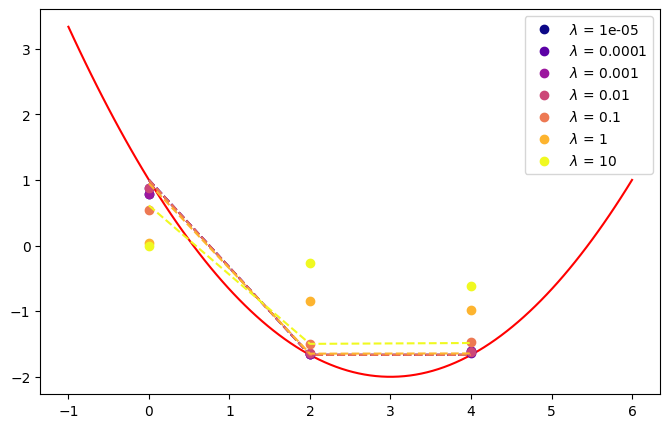

In [683]:
betas_GD = np.zeros((num_lambdas, 3))

i = 0
for lamb in lambdas: 
    betas_GD[i] = gd_momentum(X,y, gradient_C_RIDGE, lamb, Niter=300, moment = 0.93, gamma = 0.001).T
    i += 1


fig = plt.figure(figsize=(8, 5))
axs = plt.gca()

axs.plot(x,y,'r')

xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]

it = 0
for lamb in lambdas:
    ypredict = xbnew.dot(betas_GD[it])
    ypredict2 = xbnew.dot(betas_RI[it])
    axs.plot(xnew,ypredict, marker='o', linestyle = ' ', c = colors[it], label=r'$\lambda$ = {}'.format(lamb))
    axs.plot(xnew,ypredict2, linestyle='--', c = colors[it])
    it += 1
axs.legend()

Setting the number of iterations to 300, and using the eigenvalue learning rate and momentum 0.9 we get that the functions for the lower lambda values (lambda <= 0.01) are fitted well.
Having gamma bigger than 0.001, the results get bad, but for gamma = 0.001 we have a similar obersvation as for the previous fixed gamma. Decreasing gamma further makes the reults worse again. Apart from that, we have the same observations as for OLS. The ridge regression for lambdas  bigger than 0.001 seems to be worse generally.

## now for stochastic GD with scaling in form of time decay rate


can we write $\nabla C(\beta) = \sum_{i=1}^n \nabla c_i(x_i, \beta)$ ?
$$\nabla C(\beta) = 2/n X^\top (X\beta - y) + 2 \lambda= 2/n 
\begin{bmatrix} \sum_{i=1}^n x_{i,1} ( \sum_{j=1}^p x_{i,j}\beta_j - y_i) \\ \dots \\ \sum_{i=1}^n x_{i,p} ( \sum_{j=1}^p x_{i,j}\beta_j - y_i) \end{bmatrix}+ 2 \lambda $$
In particular, we have $x_{i,j} = x_i^{j-1}$, so 
$$\nabla C(\beta) = 2/n 
\begin{bmatrix} 
\sum_{i=1}^n 1 ( \sum_{j=1}^p x_{i}^{j-1} \beta_j - y_i) \\ 
\sum_{i=1}^n x_{i} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \\ 
\dots \\ 
\sum_{i=1}^n x_{i}^{p-1} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \end{bmatrix} + 2 \lambda$$

$$\nabla C(\beta) = 2/n \sum_{i=1}^n 
\begin{bmatrix} 
1 ( \sum_{j=1}^p x_{i}^{j-1} \beta_j - y_i) \\ 
 x_{i} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \\ 
\dots \\ 
 x_{i}^{p-1} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \end{bmatrix} + 2 \lambda$$
So, we can define $$ \nabla c_i(x_i, \beta) =  2/n  
\begin{bmatrix} 
1 ( \sum_{j=1}^p x_{i}^{j-1} \beta_j - y_i) \\ 
 x_{i} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \\ 
\dots \\ 
 x_{i}^{p-1} ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \end{bmatrix}+ 2 \lambda /n =2/n ( \sum_{j=1}^p x_{i}^{j-1}\beta_j - y_i) \begin{bmatrix} 1\\ x_i \\ \dots \\ x_i^{p-1} \end{bmatrix} + 2 \lambda /n$$

 So the sum of $i \in S \subset \{1, \dots, n\}$ is 
 $$ \sum_{i \in S} \nabla c_i(x_i, \beta)  =2/n ( \sum_{j=1}^p x_{i_1}^{j-1}\beta_j - y_{i_1}) \begin{bmatrix} 1\\ x_{i_1} \\ \dots \\ x_{i_1}^{p-1} \end{bmatrix}  + 2/n( \sum_{j=1}^p x_{i_2}^{j-1}\beta_j - y_{i_2}) \begin{bmatrix} 1\\ x_{i_2} \\ \dots \\ x_{i_2}^{p-1} \end{bmatrix} + \dots + 2 \lambda |S|/n = 2/n X_S^\top (X_S\beta - y_S) + 2 \lambda |S|/n $$

In [684]:
def sum_c_i(X_sub, beta, y_sub,n,lamb): # Xsub is a X from which rows are deleted, same for y_sub
    return X_sub.T @ ((X_sub @ beta) - y_sub) *2/n  + 2*lamb*y_sub.size/n

def gamma_timedecay(t,t0,t1):
    if t0 <= 0 or t1 <= 0:
        raise ValueError("t0 or t1 <= 0")
    return t0/(t+t1)


In [685]:
def sgd(X,y,sum_c_i, lamb, n_epochs=50, M=5, t0=1,t1=10, gam = 0):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    
    
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta
    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches

    for e in range(n_epochs):
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient = sum_c_i(Xi, xk, yi,n,lamb) # 1/M
            if gam:
                gamma = gam

            else: 
                gamma = gamma_timedecay(e*m + i,t0,t1)
            xk = xk - gamma*gradient
    return xk

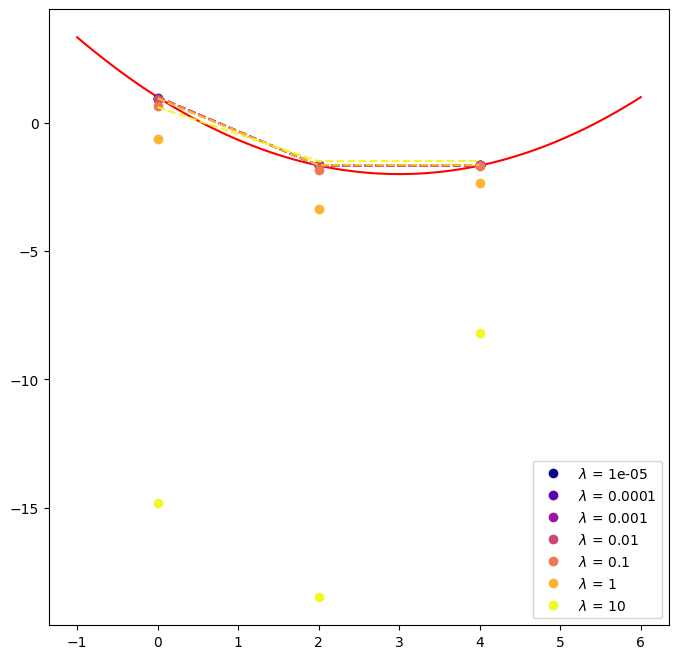

In [740]:
n_epochs = 600
M = 5 # size of the minibatches
t0, t1 = 5,80 # taking 1,10 decays faster than 5,50, eventough they have the smae starting point
gamma = 0.01


betas_GD = np.zeros((num_lambdas, 3))

i = 0
for lamb in lambdas: 
    betas_GD[i] = sgd(X,y,sum_c_i, lamb, n_epochs, M, t0,t1,gamma).T
    i += 1


fig = plt.figure(figsize=(8, 8))
axs = plt.gca()

axs.plot(x,y,'r')

xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]

it = 0
for lamb in lambdas:
    ypredict = xbnew.dot(betas_GD[it])
    ypredict2 = xbnew.dot(betas_RI[it])
    axs.plot(xnew,ypredict, marker='o', linestyle=' ', c = colors[it], label=r'$\lambda$ = {}'.format(lamb))
    axs.plot(xnew,ypredict2, linestyle='--', c = colors[it])
    it += 1

axs.legend()

Here we now implemented the stochastic gradient  method for ridge. Taking the number of batches to be 10 brings very bad reuslts for lambda = 0.01, strangely. For larger values of M  this behaviour gets stronger for even other lambdas, and for M = 5 the estimates are much closer to the true value. This was for 3000 epochs and the time decay learning rate of t0 = 5 and t1 = 70. However, for lambda = 10 the values are still relatively bad.
If we let t0 be larger the values explode. But taking t1 does not worsen that behaviour. Decreasing it to , e.g., 20 however does. So taking t1 equal to 80 with 2000 epochs works about good.
Fixing gamma the learning rate to 0.0005 also fits nicely,  But for gamma = 0.01 it fits very good for the lambdas up to 0.1, the larger are worse. For this, the number of epochs can even be decreased to 600.

## sgd with scaling in form of time decay rate + momentum


In [742]:
# note by setting momentum = 0, we have the old sgd
def sgd_momentum(X,y,sum_c_i,lamb, n_epochs=50, M=5, t0=1,t1=10, momentum = 0.9):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    change = 0
    for e in range(n_epochs):
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n,lamb)
            gamma = gamma_timedecay(e*m + i,t0,t1)
            change = gamma*gradient + change*momentum
            xk = xk - change

    return xk

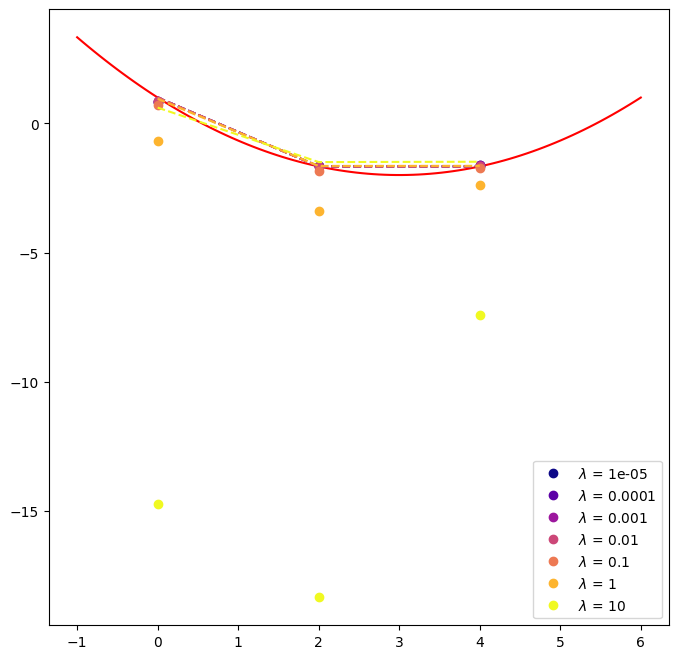

In [755]:
n_epochs = 500
M = 5 # size of the minibatches
t0, t1 = 2,60


betas_GD = np.zeros((num_lambdas, 3))
i = 0
for lamb in lambdas: 
    betas_GD[i] = sgd_momentum(X,y,sum_c_i,lamb,n_epochs, M, t0,t1, 0.9).T
    i += 1


fig = plt.figure(figsize=(8, 8))
axs = plt.gca()

axs.plot(x,y,'r')

xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]

it = 0
for lamb in lambdas:
    ypredict = xbnew.dot(betas_GD[it])
    ypredict2 = xbnew.dot(betas_RI[it])
    axs.plot(xnew,ypredict, marker='o', linestyle=' ', c = colors[it], label=r'$\lambda$ = {}'.format(lamb))
    axs.plot(xnew,ypredict2, linestyle='--', c = colors[it])
    
    it += 1

axs.legend()

Taking the momentum = 0.93, t0 = 1 and t1 = 70, and the number of epochs as low as 500, we get again good estimates for the lower lambdas values (except for lambda = 10, lambda = 1). The same observations apply that we had for the OLS regression. I did not manage to get the larger lambda values ( lambda = 10, lambda = 1)  closer to the true function value.

## ADAGRAD with SGD with & witohut momentum

In [757]:
# note by setting momentum = 0, we have the old sgd
def sgd_momentum_adagrad(X,y,sum_c_i, lamb, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, delta=1e-8):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    change = 0.0
    for e in range(n_epochs):
        Giter = 0.0
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n,lamb)
            Giter += gradient*gradient
            change = gamma*gradient/(delta + np.sqrt(Giter)) + change*momentum
            xk = xk - change

    return xk

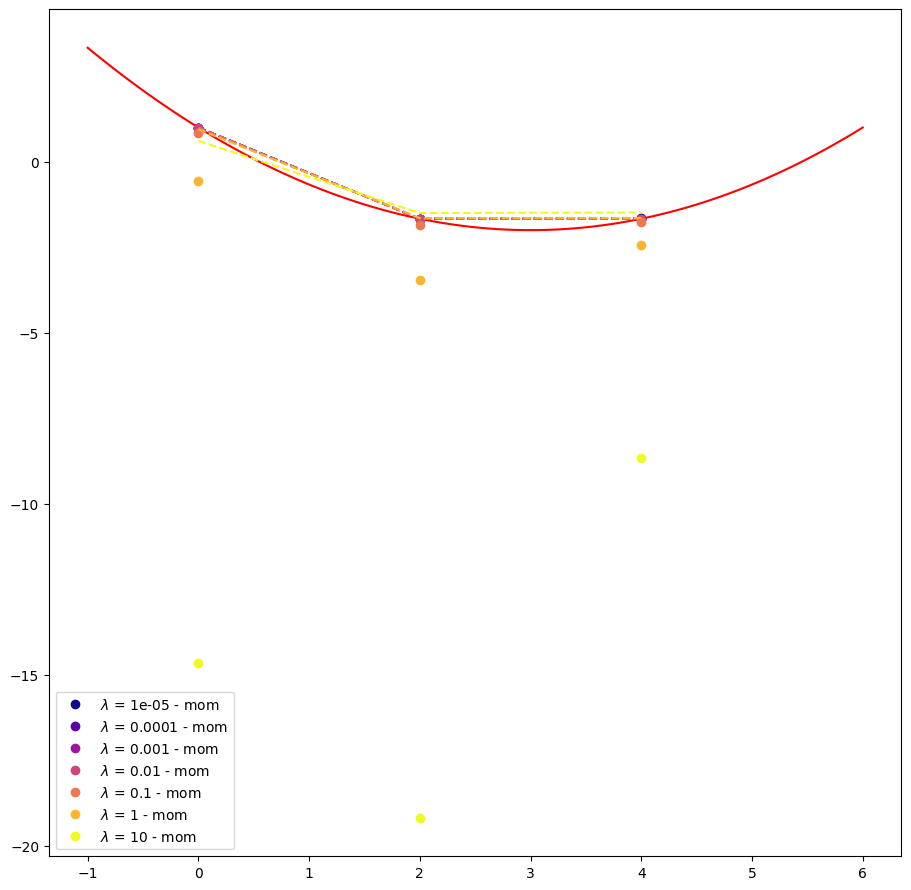

In [779]:
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8

n_epochs = 1000
gamma = 0.001
betas_GD = np.zeros((num_lambdas, 3))
betas_GD_ohnemom = np.zeros((num_lambdas, 3))
i = 0
for lamb in lambdas: 
    betas_GD[i] = sgd_momentum_adagrad(X,y,sum_c_i, lamb, n_epochs, M, gamma, momentum = 0.9, delta=1e-8).T
    betas_GD_ohnemom[i] = sgd_momentum_adagrad(X,y,sum_c_i,lamb, n_epochs, M, gamma, momentum = 0.0, delta=1e-8).T
    i += 1


fig = plt.figure(figsize=(11,11))
axs = plt.gca()

axs.plot(x,y,'r')

xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]

it = 0
for lamb in lambdas:
    ypredict = xbnew.dot(betas_GD[it])
    ypredict2 = xbnew.dot(betas_RI[it])
    ypredict3 = xbnew.dot(betas_GD_ohnemom[it])
    axs.plot(xnew,ypredict, marker='o', linestyle=' ', c = colors[it], label=r'$\lambda$ = {} - mom'.format(lamb))
    #axs.plot(xnew,ypredict3, marker='o', linestyle=' ', c = colors[it], label=r'$\lambda$ = {} - nomom'.format(lamb))
    axs.plot(xnew,ypredict2, linestyle='--', c = colors[it])
    
    it += 1

axs.legend()


Consider first no momentum: Having 500 epochs and gamma = 0.01, we get a similar result as for the previous sgd with momentum. But taking gamma = 0.001, the estimates for the smaller values are worse, but the estimates for the larger values gets better. However, if we increase the number of epochs, we achieve again the similar image where the estimates for $\lambda = 10$ are far off. For gamma = 0.05, we get very good estimates, also stable, for the lower lambda values. Taking gamma larger makes this again a bit worse.
Now consider momentum. We can observe about the sam ebehaviour as for the case with no momentum. With respect to the gamma values, it is similar, but the values are better for gamma = 0.01 than for 0.05 when considering the momentum 0.9. Increasing and decreasing does not improve this behaviour.
So, we have a good estimate for gamma = 0.001 and a momentum of 0.9 for the lower lambda values.
Again, so far I was not able to achieve a good estimate for the larger lambda values. 

## RMS PROP (SGD)

In [780]:
# note by setting momentum = 0, we have the old sgd
def sgd_rmsprop(X,y,sum_c_i, lamb, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, delta=1e-8):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    change = 0.0
    for e in range(n_epochs):
        for i in range(m):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n,lamb)
            Giter = gradient*gradient
            change = (1- momentum)*Giter + change*momentum
            xk = xk - gamma*gradient/(np.sqrt(change) + delta)

    return xk

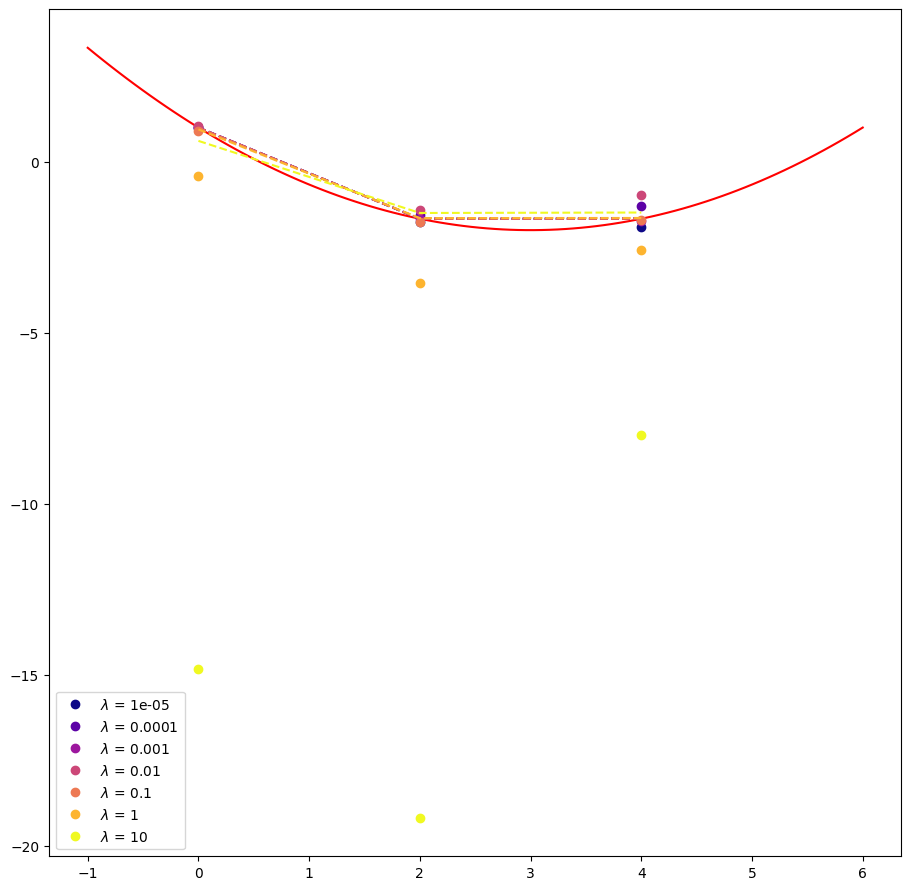

In [791]:
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8


betas_GD = np.zeros((num_lambdas, 3))
i = 0
for lamb in lambdas: 
    betas_GD[i] = sgd_momentum_adagrad(X,y,sum_c_i,lamb, n_epochs=1000, M=5, gamma=0.005, momentum = 0.95, delta=1e-8).T
    i += 1


fig = plt.figure(figsize=(11,11))
axs = plt.gca()

axs.plot(x,y,'r')

xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]

it = 0
for lamb in lambdas:
    ypredict = xbnew.dot(betas_GD[it])
    ypredict2 = xbnew.dot(betas_RI[it])
   
    axs.plot(xnew,ypredict, marker='o', linestyle=' ', c = colors[it], label=r'$\lambda$ = {}'.format(lamb))
    axs.plot(xnew,ypredict2, linestyle='--', c = colors[it])
    it += 1

axs.legend()



Now consider the RMS propagation. Again for the similar values as before we get the result where the lower lambdas are approximated good, but the larger are approximated bad.
We did not manage so far to get a better result than for the previous plots.

## ADAM(SGD)

In [793]:
# note by setting momentum = 0, we have the old sgd
def sgd_adam(X,y,sum_c_i, lamb, n_epochs=50, M=5, gamma=0.001, momentum = 0.9, secmomentum = 0.99, delta=1e-8):
    n = y.size
    if M > n:
        raise ValueError("can't take Minimbatch of size %i from sest of size %i" %(M,n))
    deg = X.shape[1]
    xk = np.random.randn(deg,1) # starting point for beta

    shuff = np.random.choice(X.shape[0], X.shape[0], False)
    X_shuff = X[shuff]
    y_shuff = y[shuff]

    m = int(y.size/M) #number of minibatches
    
    
    for e in range(n_epochs):
        mk = 0.0
        sk= 0.0
        for k in range(1, m+1):
            random_index = M*np.random.randint(m) 
            Xi = X_shuff[random_index:random_index+M]
            yi = y_shuff[random_index:random_index+M]
            gradient =  sum_c_i(Xi, xk, yi,n,lamb)
            Giter = gradient*gradient
            mk = ((1- momentum)*gradient + momentum*mk)/(1- momentum**k)
            sk = ((1- secmomentum)*Giter + secmomentum*sk)/(1-secmomentum**k)
            xk = xk - gamma*mk/(np.sqrt(sk) + delta)

    return xk

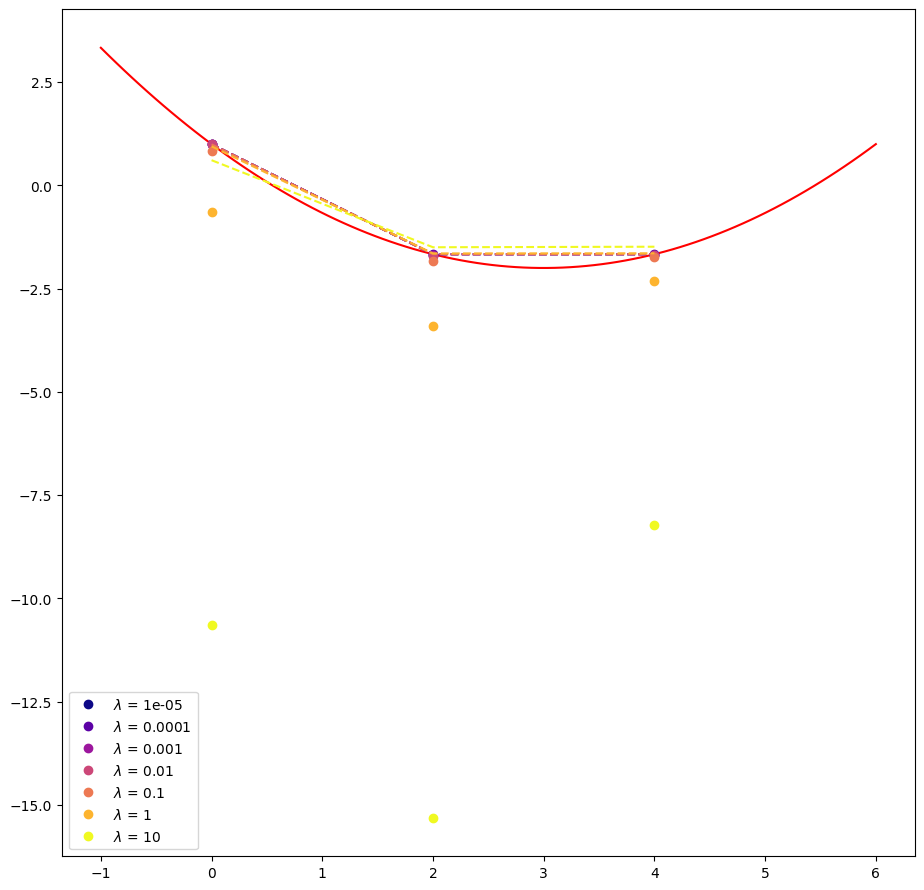

In [874]:
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8

betas_GD = np.zeros((num_lambdas, 3))
i = 0
for lamb in lambdas: 
    betas_GD[i] = sgd_adam(X,y,sum_c_i, lamb, n_epochs=500, M=5, gamma=0.01, momentum = 0.2, secmomentum = 0.93, delta=1e-8).T
    i += 1

fig = plt.figure(figsize=(11,11))
axs = plt.gca()

axs.plot(x,y,'r')

xnew = np.array([[0],[2],[4]])
xbnew = np.c_[np.ones((3,1)), xnew, xnew**2]

it = 0
for lamb in lambdas:
    ypredict = xbnew.dot(betas_GD[it])
    ypredict2 = xbnew.dot(betas_RI[it])
   
    axs.plot(xnew,ypredict, marker='o', linestyle=' ', c = colors[it], label=r'$\lambda$ = {}'.format(lamb))
    axs.plot(xnew,ypredict2, linestyle='--', c = colors[it])
    
    it += 1

axs.legend()


Finally we consider the adam method. We are again able to fit the lower lambdas nicely for example by taking gamma = 0.01, first momentum = 0.2 and second momentum = 0.93, but this can be achieved for multiple variations of gamma and the two moments. But again, if we want to minimze the larger lambda values, this comes with the cost of a worse fit of the lower lambda values. For example for gamma equal 0.001, first momentum 0.73, and the second momentum 0.93, the values for the large lambda are closeto the true function, but it is not comparable with how close we manage to get the values for the smaller lambdas to the true values.